In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Time series forecasting task

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [30]:
data = pd.read_csv('/content/drive/MyDrive/N-N-D-L/dailyclimate.csv')
print(data)

           date   meantemp   humidity  wind_speed  meanpressure
0    2017-01-01  15.913043  85.869565    2.743478     59.000000
1    2017-01-02  18.500000  77.222222    2.894444   1018.277778
2    2017-01-03  17.111111  81.888889    4.016667   1018.333333
3    2017-01-04  18.700000  70.050000    4.545000   1015.700000
4    2017-01-05  18.388889  74.944444    3.300000   1014.333333
..          ...        ...        ...         ...           ...
109  2017-04-20  34.500000  27.500000    5.562500    998.625000
110  2017-04-21  34.250000  39.375000    6.962500    999.875000
111  2017-04-22  32.900000  40.900000    8.890000   1001.600000
112  2017-04-23  32.875000  27.500000    9.962500   1002.125000
113  2017-04-24  32.000000  27.142857   12.157143   1004.142857

[114 rows x 5 columns]


In [31]:
print("Missing values:\n", data.isnull().sum())


Missing values:
 date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


In [32]:
# Drop rows with missing values
data.dropna(inplace=True)

# Convert 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Sort the dataframe based on the 'date' column
data.sort_values(by='date', inplace=True)

# Use only the 'temperature' column for this example
# You can adjust this based on your specific forecasting task
data = data[['date', 'meantemp']]

# Set 'date' column as index
data.set_index('date', inplace=True)

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Define a function to create input and target sequences
def create_sequences(data, sequence_length):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        Y.append(data[i+sequence_length])
    return np.array(X), np.array(Y)

# Define sequence length (number of timesteps to look back)
sequence_length = 30

# Create input and target sequences
X, Y = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

# Print shapes of training and testing sets
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (67, 30, 1)
Y_train shape: (67, 1)
X_test shape: (17, 30, 1)
Y_test shape: (17, 1)


Epoch 1/50
2/2 [==============================] - 20s 1s/step - loss: 0.2065 - val_loss: 0.4412
Epoch 2/50
2/2 [==============================] - 0s 75ms/step - loss: 0.1327 - val_loss: 0.2509
Epoch 3/50
2/2 [==============================] - 0s 80ms/step - loss: 0.0730 - val_loss: 0.0899
Epoch 4/50
2/2 [==============================] - 0s 83ms/step - loss: 0.0306 - val_loss: 0.0080
Epoch 5/50
2/2 [==============================] - 0s 83ms/step - loss: 0.0258 - val_loss: 0.0298
Epoch 6/50
2/2 [==============================] - 0s 69ms/step - loss: 0.0484 - val_loss: 0.0150
Epoch 7/50
2/2 [==============================] - 0s 70ms/step - loss: 0.0332 - val_loss: 0.0092
Epoch 8/50
2/2 [==============================] - 0s 84ms/step - loss: 0.0204 - val_loss: 0.0285
Epoch 9/50
2/2 [==============================] - 0s 82ms/step - loss: 0.0193 - val_loss: 0.0498
Epoch 10/50
2/2 [==============================] - 0s 74ms/step - loss: 0.0249 - val_loss: 0.0584
Epoch 11/50
2/2 [=============

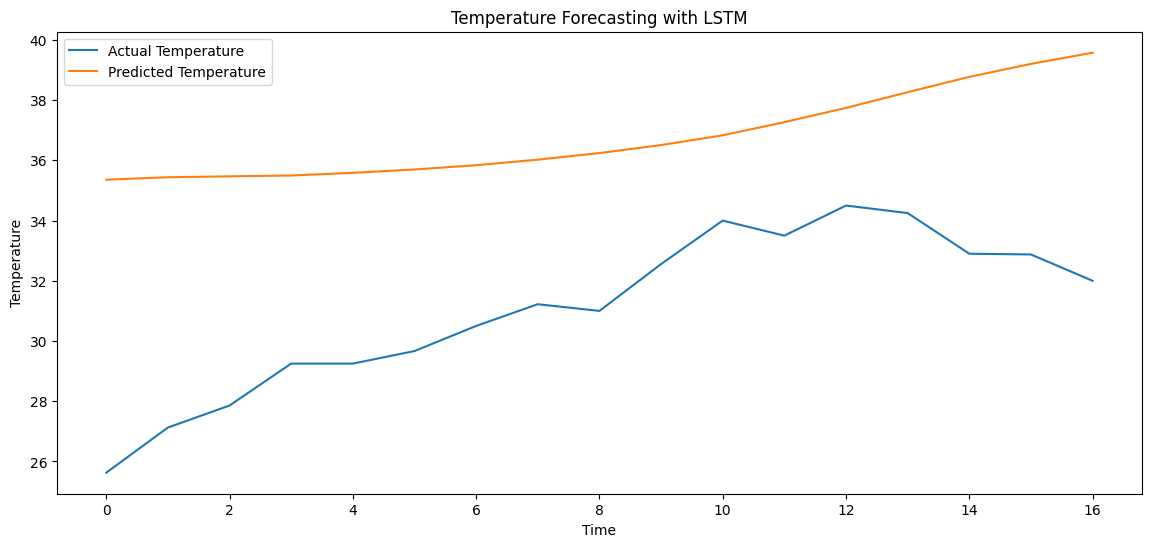

In [33]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(Y_test)

# Evaluate the model
mae = mean_absolute_error(actual, predictions)
rmse = np.sqrt(mean_squared_error(actual, predictions))
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

# Plot the results
plt.figure(figsize=(14, 6))
plt.plot(actual, label='Actual Temperature')
plt.plot(predictions, label='Predicted Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Forecasting with LSTM')
plt.legend()
plt.show()

Image Classification Task

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()


# Reshape and normalize the input data
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1) / 255.0
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1) / 255.0

# Define the CNN model
def create_model(optimizer='adam'):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the CNN model
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define hyperparameters for grid search
param_grid = {
    'batch_size': [32, 64],
    'epochs': [5, 10],
    'optimizer': ['adam', 'rmsprop'],
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

# Print the best parameters and accuracy
print("Best Parameters: ", grid_result.best_params_)
print("Best Accuracy: ", grid_result.best_score_)

# Train the final model with the best parameters
final_model = create_model(optimizer=grid_result.best_params_['optimizer'])
history = final_model.fit(X_train, y_train, batch_size=grid_result.best_params_['batch_size'], epochs=grid_result.best_params_['epochs'], validation_split=0.2, callbacks=[ReduceLROnPlateau()])

# Evaluate the model on the test set
test_loss, test_acc = final_model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'